<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/2_dimensionality_reduction_using_stacked_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction using Stacked Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



Just like other neural networks, autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. 

Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (and it is unlikely to generalize well to new instances).

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/stacked-autoencoder.png?raw=1' width='800'/>

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich.

For example, an autoencoder for MNIST may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons.


## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Implementing a Stacked Autoencoder Using Keras

You can implement a stacked autoencoder very much like a regular deep MLP. In particular, the same techniques we used for training deep nets can be
applied.

For example, the following code builds a stacked autoencoder for Fashion MNIST using the SELU activation function:

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784
    keras.layers.Dense(100, activation='selu'),    
    keras.layers.Dense(30, activation='selu')
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),  # decoder takes codings of size 30 (output by the encoder)
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_autoencoder = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = stacked_autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 6s 105us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 6s 107us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3044 - val_rounded_accuracy: 0.9101
Epoch 4/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9277
Epoch 5/20
55000/55000 [==============================] - 6s 102us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2925 - val_rounded_accuracy: 0.9274
Epoch 6/20
55000/55000 [==============================] - 6s 101us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val

## Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

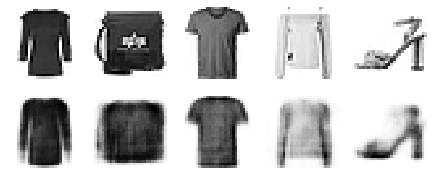

In [7]:
show_reconstructions(stacked_autoencoder)

The reconstructions are recognizable, but a bit too lossy. We may need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger. But if we make the network too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data.

## Visualizing the Fashion MNIST Dataset

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms.

But one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization.

Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality
down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm
to reduce the dimensionality down to 2 for visualization:

In [0]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

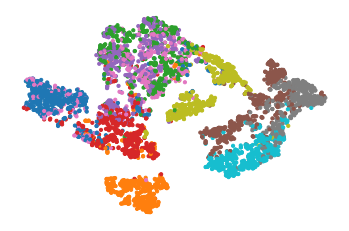

In [9]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')
plt.show()

Let's make this diagram a bit prettier:

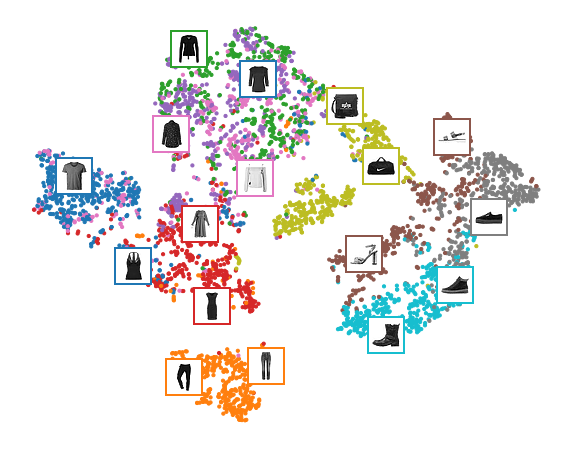

In [10]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

plt.show()

It shows the resulting scatterplot (beautified a bit by displaying some of the images). The t-SNE algorithm identified several clusters which match the classes reasonably well (each class is represented with a different color).

So, autoencoders can be used for dimensionality reduction. Another application is for unsupervised pretraining.